In [10]:
!pip install openai colorama

# MultiAgent Pattern

<img src="https://drive.google.com/uc?id=16Fjbqg5a1Yl6x1pPhcL4uVuS0JRacdrm" alt="Alt text" width="500"/>

---

You may have heard about frameworks like [CrewAI](https://www.crewai.com/) or [AutoGen](https://microsoft.github.io/autogen/0.2/), which allow you to create multi-agent applications.

These frameworks implement different variations of the multi-agent pattern, in which tasks are divided into **smaller subtasks executed by different roles** (e.g. one agent can be a software engineer, another a project manager, etc.)

For this final lesson, I wanted to build something more elaborate. That's why I've been working on a 𝐦𝐢𝐧𝐢𝐦𝐚𝐥𝐢𝐬𝐭 𝐯𝐞𝐫𝐬𝐢𝐨𝐧 𝐨𝐟 𝐂𝐫𝐞𝐰𝐀𝐈, drawing inspiration from two of its key concepts: 𝐂𝐫𝐞𝐰 and 𝐀𝐠𝐞𝐧𝐭.

Additionally, I've also borrowed ideas from [𝐀𝐢𝐫𝐟𝐥𝐨𝐰](https://airflow.apache.org/)'𝐬 𝐝𝐞𝐬𝐢𝐠𝐧 𝐩𝐡𝐢𝐥𝐨𝐬𝐨𝐩𝐡𝐲, using >> and << to define dependencies between my agents. In this micro-CrewAI, 𝐚𝐠𝐞𝐧𝐭𝐬 are equivalent to 𝐀𝐢𝐫𝐟𝐥𝐨𝐰 𝐓𝐚𝐬𝐤𝐬 and the 𝐂𝐫𝐞𝐰 is equivalent to an 𝐀𝐢𝐫𝐟𝐥𝐨𝐰 𝐃𝐀𝐆.

## The Agent Class

First of all, we need an **Agent Class**. This class implements an
Agent, and internally it implements the ReAct technique. We'll also need to import all the code related with the Tools from Module 3 and additional helpers.

#### General Helpers

In [11]:
# @title
import re
import time

from colorama import Fore
from colorama import Style

from graphviz import Digraph  # type: ignore

from dataclasses import dataclass


def completions_create(client, messages: list, model: str) -> str:
    """
    Sends a request to the client's `completions.create` method to interact with the language model.

    Args:
        client (OpenAI): The OpenAI client object
        messages (list[dict]): A list of message objects containing chat history for the model.
        model (str): The model to use for generating tool calls and responses.

    Returns:
        str: The content of the model's response.
    """
    response = client.chat.completions.create(messages=messages, model=model)
    return str(response.choices[0].message.content)


def build_prompt_structure(prompt: str, role: str, tag: str = "") -> dict:
    """
    Builds a structured prompt that includes the role and content.

    Args:
        prompt (str): The actual content of the prompt.
        role (str): The role of the speaker (e.g., user, assistant).

    Returns:
        dict: A dictionary representing the structured prompt.
    """
    if tag:
        prompt = f"<{tag}>{prompt}</{tag}>"
    return {"role": role, "content": prompt}

def update_chat_history(history: list, msg: str, role: str):
    """
    Updates the chat history by appending the latest response.

    Args:
        history (list): The list representing the current chat history.
        msg (str): The message to append.
        role (str): The role type (e.g. 'user', 'assistant', 'system')
    """
    history.append(build_prompt_structure(prompt=msg, role=role))


class ChatHistory(list):
    def __init__(self, messages: list | None = None, total_length: int = -1):
        """Initialise the queue with a fixed total length.

        Args:
            messages (list | None): A list of initial messages
            total_length (int): The maximum number of messages the chat history can hold.
        """
        if messages is None:
            messages = []

        super().__init__(messages)
        self.total_length = total_length

    def append(self, msg: str):
        """Add a message to the queue.

        Args:
            msg (str): The message to be added to the queue
        """
        if len(self) == self.total_length:
            self.pop(0)
        super().append(msg)



class FixedFirstChatHistory(ChatHistory):
    def __init__(self, messages: list | None = None, total_length: int = -1):
        """Initialise the queue with a fixed total length.

        Args:
            messages (list | None): A list of initial messages
            total_length (int): The maximum number of messages the chat history can hold.
        """
        super().__init__(messages, total_length)

    def append(self, msg: str):
        """Add a message to the queue. The first messaage will always stay fixed.

        Args:
            msg (str): The message to be added to the queue
        """
        if len(self) == self.total_length:
            self.pop(1)
        super().append(msg)

def fancy_print(message: str) -> None:
    """
    Displays a fancy print message.

    Args:
        message (str): The message to display.
    """
    print(Style.BRIGHT + Fore.CYAN + f"\n{'=' * 50}")
    print(Fore.MAGENTA + f"{message}")
    print(Style.BRIGHT + Fore.CYAN + f"{'=' * 50}\n")
    time.sleep(0.5)


def fancy_step_tracker(step: int, total_steps: int) -> None:
    """
    Displays a fancy step tracker for each iteration of the generation-reflection loop.

    Args:
        step (int): The current step in the loop.
        total_steps (int): The total number of steps in the loop.
    """
    fancy_print(f"STEP {step + 1}/{total_steps}")


@dataclass
class TagContentResult:
    """
    A data class to represent the result of extracting tag content.

    Attributes:
        content (List[str]): A list of strings containing the content found between the specified tags.
        found (bool): A flag indicating whether any content was found for the given tag.
    """

    content: list[str]
    found: bool


def extract_tag_content(text: str, tag: str) -> TagContentResult:
    """
    Extracts all content enclosed by specified tags (e.g., <thought>, <response>, etc.).

    Parameters:
        text (str): The input string containing multiple potential tags.
        tag (str): The name of the tag to search for (e.g., 'thought', 'response').

    Returns:
        dict: A dictionary with the following keys:
            - 'content' (list): A list of strings containing the content found between the specified tags.
            - 'found' (bool): A flag indicating whether any content was found for the given tag.
    """
    # Build the regex pattern dynamically to find multiple occurrences of the tag
    tag_pattern = rf"<{tag}>(.*?)</{tag}>"

    # Use findall to capture all content between the specified tag
    matched_contents = re.findall(tag_pattern, text, re.DOTALL)

    # Return the dataclass instance with the result
    return TagContentResult(
        content=[content.strip() for content in matched_contents],
        found=bool(matched_contents),
    )

class Crew:
    """
    A class representing a crew of agents working together.

    This class manages a group of agents, their dependencies, and provides methods
    for running the agents in a topologically sorted order.

    Attributes:
        current_crew (Crew): Class-level variable to track the active Crew context.
        agents (list): A list of agents in the crew.
    """

    current_crew = None

    def __init__(self):
        self.agents = []

    def __enter__(self):
        """
        Enters the context manager, setting this crew as the current active context.

        Returns:
            Crew: The current Crew instance.
        """
        Crew.current_crew = self
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Exits the context manager, clearing the active context.

        Args:
            exc_type: The exception type, if an exception was raised.
            exc_val: The exception value, if an exception was raised.
            exc_tb: The traceback, if an exception was raised.
        """
        Crew.current_crew = None

    def add_agent(self, agent):
        """
        Adds an agent to the crew.

        Args:
            agent: The agent to be added to the crew.
        """
        self.agents.append(agent)

    @staticmethod
    def register_agent(agent):
        """
        Registers an agent with the current active crew context.

        Args:
            agent: The agent to be registered.
        """
        if Crew.current_crew is not None:
            Crew.current_crew.add_agent(agent)

    def topological_sort(self):
        """
        Performs a topological sort of the agents based on their dependencies.

        Returns:
            list: A list of agents sorted in topological order.

        Raises:
            ValueError: If there's a circular dependency among the agents.
        """
        in_degree = {agent: len(agent.dependencies) for agent in self.agents}
        queue = deque([agent for agent in self.agents if in_degree[agent] == 0])

        sorted_agents = []

        while queue:
            current_agent = queue.popleft()
            sorted_agents.append(current_agent)

            for dependent in current_agent.dependents:
                in_degree[dependent] -= 1
                if in_degree[dependent] == 0:
                    queue.append(dependent)

        if len(sorted_agents) != len(self.agents):
            raise ValueError(
                "Circular dependencies detected among agents, preventing a valid topological sort"
            )

        return sorted_agents

    def plot(self):
        """
        Plots the Directed Acyclic Graph (DAG) of agents in the crew using Graphviz.

        Returns:
            Digraph: A Graphviz Digraph object representing the agent dependencies.
        """
        dot = Digraph(format="png")  # Set format to PNG for inline display

        # Add nodes and edges for each agent in the crew
        for agent in self.agents:
            dot.node(agent.name)
            for dependency in agent.dependencies:
                dot.edge(dependency.name, agent.name)
        return dot

    def run(self):
        """
        Runs all agents in the crew in topologically sorted order.

        This method executes each agent's run method and prints the results.
        """
        sorted_agents = self.topological_sort()
        for agent in sorted_agents:
            fancy_print(f"RUNNING AGENT: {agent}")
            print(Fore.RED + f"{agent.run()}")


#### Tools

In [12]:
# @title
import json
import re
from dataclasses import dataclass
from typing import Callable


def get_fn_signature(fn: Callable) -> dict:
    """
    Generates the signature for a given function.

    Args:
        fn (Callable): The function whose signature needs to be extracted.

    Returns:
        dict: A dictionary containing the function's name, description,
              and parameter types.
    """
    fn_signature: dict = {
        "name": fn.__name__,
        "description": fn.__doc__,
        "parameters": {"properties": {}},
    }
    schema = {
        k: {"type": v.__name__} for k, v in fn.__annotations__.items() if k != "return"
    }
    fn_signature["parameters"]["properties"] = schema
    return fn_signature


def validate_arguments(tool_call: dict, tool_signature: dict) -> dict:
    """
    Validates and converts arguments in the input dictionary to match the expected types.

    Args:
        tool_call (dict): A dictionary containing the arguments passed to the tool.
        tool_signature (dict): The expected function signature and parameter types.

    Returns:
        dict: The tool call dictionary with the arguments converted to the correct types if necessary.
    """
    properties = tool_signature["parameters"]["properties"]

    # TODO: This is overly simplified but enough for simple Tools.
    type_mapping = {
        "int": int,
        "str": str,
        "bool": bool,
        "float": float,
    }

    for arg_name, arg_value in tool_call["arguments"].items():
        expected_type = properties[arg_name].get("type")

        if not isinstance(arg_value, type_mapping[expected_type]):
            tool_call["arguments"][arg_name] = type_mapping[expected_type](arg_value)

    return tool_call


class Tool:
    """
    A class representing a tool that wraps a callable and its signature.

    Attributes:
        name (str): The name of the tool (function).
        fn (Callable): The function that the tool represents.
        fn_signature (str): JSON string representation of the function's signature.
    """

    def __init__(self, name: str, fn: Callable, fn_signature: str):
        self.name = name
        self.fn = fn
        self.fn_signature = fn_signature

    def __str__(self):
        return self.fn_signature

    def run(self, **kwargs):
        """
        Executes the tool (function) with provided arguments.

        Args:
            **kwargs: Keyword arguments passed to the function.

        Returns:
            The result of the function call.
        """
        return self.fn(**kwargs)


def tool(fn: Callable):
    """
    A decorator that wraps a function into a Tool object.

    Args:
        fn (Callable): The function to be wrapped.

    Returns:
        Tool: A Tool object containing the function, its name, and its signature.
    """

    def wrapper():
        fn_signature = get_fn_signature(fn)
        return Tool(
            name=fn_signature.get("name"), fn=fn, fn_signature=json.dumps(fn_signature)
        )

    return wrapper()


@dataclass
class TagContentResult:
    """
    A data class to represent the result of extracting tag content.

    Attributes:
        content (List[str]): A list of strings containing the content found between the specified tags.
        found (bool): A flag indicating whether any content was found for the given tag.
    """

    content: list[str]
    found: bool


def extract_tag_content(text: str, tag: str) -> TagContentResult:
    """
    Extracts all content enclosed by specified tags (e.g., <thought>, <response>, etc.).

    Parameters:
        text (str): The input string containing multiple potential tags.
        tag (str): The name of the tag to search for (e.g., 'thought', 'response').

    Returns:
        dict: A dictionary with the following keys:
            - 'content' (list): A list of strings containing the content found between the specified tags.
            - 'found' (bool): A flag indicating whether any content was found for the given tag.
    """
    # Build the regex pattern dynamically to find multiple occurrences of the tag
    tag_pattern = rf"<{tag}>(.*?)</{tag}>"

    # Use findall to capture all content between the specified tag
    matched_contents = re.findall(tag_pattern, text, re.DOTALL)

    # Return the dataclass instance with the result
    return TagContentResult(
        content=[content.strip() for content in matched_contents],
        found=bool(matched_contents),
    )

#### ReAct Agent

In [13]:
# @title
import json
import re

from colorama import Fore

BASE_SYSTEM_PROMPT = ""


REACT_SYSTEM_PROMPT = """
You operate by running a loop with the following steps: Thought, Action, Observation.
You are provided with function signatures within <tools></tools> XML tags.
You may call one or more functions to assist with the user query. Don' make assumptions about what values to plug
into functions. Pay special attention to the properties 'types'. You should use those types as in a Python dict.

For each function call return a json object with function name and arguments within <tool_call></tool_call> XML tags as follows:

<tool_call>
{"name": <function-name>,"arguments": <args-dict>, "id": <monotonically-increasing-id>}
</tool_call>

Here are the available tools / actions:

<tools>
%s
</tools>

Example session:

<question>What's the current temperature in Madrid?</question>
<thought>I need to get the current weather in Madrid</thought>
<tool_call>{"name": "get_current_weather","arguments": {"location": "Madrid", "unit": "celsius"}, "id": 0}</tool_call>

You will be called again with this:

<observation>{0: {"temperature": 25, "unit": "celsius"}}</observation>

You then output:

<response>The current temperature in Madrid is 25 degrees Celsius</response>

Additional constraints:

- If the user asks you something unrelated to any of the tools above, answer freely enclosing your answer with <response></response> tags.
"""


class ReactAgent:
    """
    A class that represents an agent using the ReAct logic that interacts with tools to process
    user inputs, make decisions, and execute tool calls. The agent can run interactive sessions,
    collect tool signatures, and process multiple tool calls in a given round of interaction.

    Attributes:
        client (OpenAI): The OpenAI client used to handle model-based completions.
        model (str): The name of the model used for generating responses. Default is "gpt-4o".
        tools (list[Tool]): A list of Tool instances available for execution.
        tools_dict (dict): A dictionary mapping tool names to their corresponding Tool instances.
    """

    def __init__(
        self,
        tools: Tool | list[Tool],
        model: str = "gpt-4o",
        system_prompt: str = BASE_SYSTEM_PROMPT,
    ) -> None:
        self.client = OpenAI(
            api_key=userdata.get('OpenAI_API_Key')
        )
        self.model = model
        self.system_prompt = system_prompt
        self.tools = tools if isinstance(tools, list) else [tools]
        self.tools_dict = {tool.name: tool for tool in self.tools}

    def add_tool_signatures(self) -> str:
        """
        Collects the function signatures of all available tools.

        Returns:
            str: A concatenated string of all tool function signatures in JSON format.
        """
        return "".join([tool.fn_signature for tool in self.tools])

    def process_tool_calls(self, tool_calls_content: list) -> dict:
        """
        Processes each tool call, validates arguments, executes the tools, and collects results.

        Args:
            tool_calls_content (list): List of strings, each representing a tool call in JSON format.

        Returns:
            dict: A dictionary where the keys are tool call IDs and values are the results from the tools.
        """
        observations = {}
        for tool_call_str in tool_calls_content:
            tool_call = json.loads(tool_call_str)
            tool_name = tool_call["name"]
            tool = self.tools_dict[tool_name]

            print(Fore.GREEN + f"\nUsing Tool: {tool_name}")

            # Validate and execute the tool call
            validated_tool_call = validate_arguments(
                tool_call, json.loads(tool.fn_signature)
            )
            print(Fore.GREEN + f"\nTool call dict: \n{validated_tool_call}")

            result = tool.run(**validated_tool_call["arguments"])
            print(Fore.GREEN + f"\nTool result: \n{result}")

            # Store the result using the tool call ID
            observations[validated_tool_call["id"]] = result

        return observations

    def run(
        self,
        user_msg: str,
        max_rounds: int = 10,
    ) -> str:
        """
        Executes a user interaction session, where the agent processes user input, generates responses,
        handles tool calls, and updates chat history until a final response is ready or the maximum
        number of rounds is reached.

        Args:
            user_msg (str): The user's input message to start the interaction.
            max_rounds (int, optional): Maximum number of interaction rounds the agent should perform. Default is 10.

        Returns:
            str: The final response generated by the agent after processing user input and any tool calls.
        """
        user_prompt = build_prompt_structure(
            prompt=user_msg, role="user", tag="question"
        )
        if self.tools:
            self.system_prompt += (
                "\n" + REACT_SYSTEM_PROMPT % self.add_tool_signatures()
            )

        chat_history = ChatHistory(
            [
                build_prompt_structure(
                    prompt=self.system_prompt,
                    role="system",
                ),
                user_prompt,
            ]
        )

        if self.tools:
            # Run the ReAct loop for max_rounds
            for _ in range(max_rounds):

                completion = completions_create(self.client, chat_history, self.model)

                response = extract_tag_content(str(completion), "response")
                if response.found:
                    return response.content[0]

                thought = extract_tag_content(str(completion), "thought")
                tool_calls = extract_tag_content(str(completion), "tool_call")

                update_chat_history(chat_history, completion, "assistant")

                print(Fore.MAGENTA + f"\nThought: {thought.content[0]}")

                if tool_calls.found:
                    observations = self.process_tool_calls(tool_calls.content)
                    print(Fore.BLUE + f"\nObservations: {observations}")
                    update_chat_history(chat_history, f"{observations}", "user")

        return completions_create(self.client, chat_history, self.model)

Now that we have all the relevant code from previous modules imported, it's time to define the Agent.

In [14]:
from openai import OpenAI
from google.colab import userdata
from textwrap import dedent

class Agent:
    """
    Represents an AI agent that can work as part of a team to complete tasks.

    This class implements an agent with dependencies, context handling, and task execution capabilities.
    It can be used in a multi-agent system where agents collaborate to solve complex problems.

    Attributes:
        name (str): The name of the agent.
        backstory (str): The backstory or background of the agent.
        task_description (str): A description of the task assigned to the agent.
        task_expected_output (str): The expected format or content of the task output.
        react_agent (ReactAgent): An instance of ReactAgent used for generating responses.
        dependencies (list[Agent]): A list of Agent instances that this agent depends on.
        dependents (list[Agent]): A list of Agent instances that depend on this agent.
        context (str): Accumulated context information from other agents.

    Args:
        name (str): The name of the agent.
        backstory (str): The backstory or background of the agent.
        task_description (str): A description of the task assigned to the agent.
        task_expected_output (str, optional): The expected format or content of the task output. Defaults to "".
        tools (list[Tool] | None, optional): A list of Tool instances available to the agent. Defaults to None.
        llm (str, optional): The name of the language model to use. Defaults to "gpt-4o".
    """

    def __init__(
        self,
        name: str,
        backstory: str,
        task_description: str,
        task_expected_output: str = "",
        tools: list[Tool] | None = None,
        llm: str = "gpt-4o",
    ):
        self.name = name
        self.backstory = backstory
        self.task_description = task_description
        self.task_expected_output = task_expected_output
        self.react_agent = ReactAgent(
            model=llm, system_prompt=self.backstory, tools=tools or []
        )

        self.dependencies: list[Agent] = []  # Agents that this agent depends on
        self.dependents: list[Agent] = []  # Agents that depend on this agent

        self.context = ""

        # Automatically register this agent to the active Crew context if one exists
        Crew.register_agent(self)

    def __repr__(self):
        return f"{self.name}"

    def __rshift__(self, other):
        """
        Defines the '>>' operator. This operator is used to indicate agent dependency.

        Args:
            other (Agent): The agent that depends on this agent.
        """
        self.add_dependent(other)
        return other  # Allow chaining

    def __lshift__(self, other):
        """
        Defines the '<<' operator to indicate agent dependency in reverse.

        Args:
            other (Agent): The agent that this agent depends on.

        Returns:
            Agent: The `other` agent to allow for chaining.
        """
        self.add_dependency(other)
        return other  # Allow chaining

    def __rrshift__(self, other):
        """
        Defines the '<<' operator.This operator is used to indicate agent dependency.

        Args:
            other (Agent): The agent that this agent depends on.
        """
        self.add_dependency(other)
        return self  # Allow chaining

    def __rlshift__(self, other):
        """
        Defines the '<<' operator when evaluated from right to left.
        This operator is used to indicate agent dependency in the normal order.

        Args:
            other (Agent): The agent that depends on this agent.

        Returns:
            Agent: The current agent (self) to allow for chaining.
        """
        self.add_dependent(other)
        return self  # Allow chaining

    def add_dependency(self, other):
        """
        Adds a dependency to this agent.

        Args:
            other (Agent | list[Agent]): The agent(s) that this agent depends on.

        Raises:
            TypeError: If the dependency is not an Agent or a list of Agents.
        """
        if isinstance(other, Agent):
            self.dependencies.append(other)
            other.dependents.append(self)
        elif isinstance(other, list) and all(isinstance(item, Agent) for item in other):
            for item in other:
                self.dependencies.append(item)
                item.dependents.append(self)
        else:
            raise TypeError("The dependency must be an instance or list of Agent.")

    def add_dependent(self, other):
        """
        Adds a dependent to this agent.

        Args:
            other (Agent | list[Agent]): The agent(s) that depend on this agent.

        Raises:
            TypeError: If the dependent is not an Agent or a list of Agents.
        """
        if isinstance(other, Agent):
            other.dependencies.append(self)
            self.dependents.append(other)
        elif isinstance(other, list) and all(isinstance(item, Agent) for item in other):
            for item in other:
                item.dependencies.append(self)
                self.dependents.append(item)
        else:
            raise TypeError("The dependent must be an instance or list of Agent.")

    def receive_context(self, input_data):
        """
        Receives and stores context information from other agents.

        Args:
            input_data (str): The context information to be added.
        """
        self.context += f"{self.name} received context: \n{input_data}"

    def create_prompt(self):
        """
        Creates a prompt for the agent based on its task description, expected output, and context.

        Returns:
            str: The formatted prompt string.
        """
        prompt = dedent(
            f"""
        You are an AI agent. You are part of a team of agents working together to complete a task.
        I'm going to give you the task description enclosed in <task_description></task_description> tags. I'll also give
        you the available context from the other agents in <context></context> tags. If the context
        is not available, the <context></context> tags will be empty. You'll also receive the task
        expected output enclosed in <task_expected_output></task_expected_output> tags. With all this information
        you need to create the best possible response, always respecting the format as describe in
        <task_expected_output></task_expected_output> tags. If expected output is not available, just create
        a meaningful response to complete the task.

        <task_description>
        {self.task_description}
        </task_description>

        <task_expected_output>
        {self.task_expected_output}
        </task_expected_output>

        <context>
        {self.context}
        </context>

        Your response:
        """
        ).strip()

        return prompt

    def run(self):
        """
        Runs the agent's task and generates the output.

        This method creates a prompt, runs it through the ReactAgent, and passes the output to all dependent agents.

        Returns:
            str: The output generated by the agent.
        """
        msg = self.create_prompt()
        output = self.react_agent.run(user_msg=msg)

        # Pass the output to all dependents
        for dependent in self.dependents:
            dependent.receive_context(output)
        return output


Let's create some example agent, to see how it works.

In [15]:
agent_example = Agent(
    name="Poet Agent",
    backstory="You are a well-known poet, who enjoys creating high quality poetry.",
    task_description="Write a poem about the meaning of life in less than 6 lines",
    task_expected_output="Just output the poem, without any title or introductory sentences",
)

In [16]:
print(agent_example.run())

In life's embrace, dreams intertwine,  
Moments whisper, softly divine.  
Seek within the silence of night,  
Find in love your guiding light.  
Dance with time, where answers reside,  
Feel the pulse of life's gentle tide.  


You can also associate tools with the agent. Let's create a tool for writing some string into a CSV.

In [17]:
@tool
def write_str_to_txt(string_data: str, txt_filename: str):
    """
    Writes a string to a txt file.

    This function takes a string and writes it to a text file. If the file already exists,
    it will be overwritten with the new data.

    Args:
        string_data (str): The string containing the data to be written to the file.
        txt_filename (str): The name of the text file to which the data should be written.
    """
    # Write the string data to the text file
    with open(txt_filename, mode='w', encoding='utf-8') as file:
        file.write(string_data)

    print(f"Data successfully written to {txt_filename}")

In [18]:
agent_tool_example = Agent(
    name="Writer Agent",
    backstory="You are a language model specialised in writing text into .txt files",
    task_description="Write the string 'This is a Tool Agent' into './tool_agent_example.txt'",
    task_expected_output="A .txt file containing the given string",
    tools=write_str_to_txt,
)

In [19]:
agent_tool_example.run()


Thought: The task requires me to write the string 'This is a Tool Agent' into a file named 'tool_agent_example.txt'. I will use the provided function to perform this task.

Using Tool: write_str_to_txt

Tool call dict: 
{'name': 'write_str_to_txt', 'arguments': {'string_data': 'This is a Tool Agent', 'txt_filename': 'tool_agent_example.txt'}, 'id': 0}
Data successfully written to tool_agent_example.txt

Tool result: 
None

Observations: {0: None}


"The string 'This is a Tool Agent' has been successfully written to 'tool_agent_example.txt'."

####  Defining Agent Dependencies

Let's define two agents now.


In [20]:
agent_1 = Agent(
    name="Poet Agent",
    backstory="You are a well-known poet, who enjoys creating high quality poetry.",
    task_description="Write a poem about the meaning of life in 4 lines",
    task_expected_output="Just output the poem, without any title or introductory sentences",
)

agent_2 = Agent(
    name="Poem Translator Agent",
    backstory="You are an expert translator especially skilled in Ancient Greek",
    task_description="Translate a poem into Ancient Greek",
    task_expected_output="Just output the translated poem and nothing else"
)

We can define the agent dependencies using the `>>` operator.

In [22]:
agent_1 >> agent_2

Poem Translator Agent

This means `agent_2` depends on `agent_1`. We can check the dependencies and dependents of both agents.

In [23]:
print("Agent 1 dependencies: ", agent_1.dependencies)
print("Agent 1 dependents: ", agent_1.dependents)
print("Agent 2 dependencies: ", agent_2.dependencies)
print("Agent 2 dependents: ", agent_2.dependents)

Agent 1 dependencies:  []
Agent 1 dependents:  [Poem Translator Agent, Poem Translator Agent]
Agent 2 dependencies:  [Poet Agent, Poet Agent]
Agent 2 dependents:  []


Now, if we run `agent_1`, the results will be added to `agent_2`'s context.

In [24]:
print(agent_1.run())

In life’s soft breath, dreams waltz and glide,  
Where time and love in whispers confide.  
In fleeting moments, the essence we find,  
A dance of hearts, eternally entwined.


In [25]:
print(agent_2.context)

Poem Translator Agent received context: 
In life’s soft breath, dreams waltz and glide,  
Where time and love in whispers confide.  
In fleeting moments, the essence we find,  
A dance of hearts, eternally entwined.Poem Translator Agent received context: 
In life’s soft breath, dreams waltz and glide,  
Where time and love in whispers confide.  
In fleeting moments, the essence we find,  
A dance of hearts, eternally entwined.


Now, if we run the second agent, it will use the context received from the previous agent to generate its output.

In [26]:
print(agent_2.run())

ἐν τῇ τοῦ βίου μαλθακᾷ πνοῇ, ὄνειροι ἐπὶ χοροῖς ἐπικευθμένος,  
ὅπου χρὸνος καὶ ἔρως ἐν ψιθυρισμοῖς ἐμπιστεύονται.  
ἐν ταυτίαις στιγμαῖς, τὴν οὐσίαν εὑρίσκομεν,  
χορός καρδιῶν, αἰεί συνδεδεμένος.


## The Crew

In [27]:
from collections import deque

from colorama import Fore
from graphviz import Digraph  # type: ignore

class Crew:
    """
    A class representing a crew of agents working together.

    This class manages a group of agents, their dependencies, and provides methods
    for running the agents in a topologically sorted order.

    Attributes:
        current_crew (Crew): Class-level variable to track the active Crew context.
        agents (list): A list of agents in the crew.
    """

    current_crew = None

    def __init__(self):
        self.agents = []

    def __enter__(self):
        """
        Enters the context manager, setting this crew as the current active context.

        Returns:
            Crew: The current Crew instance.
        """
        Crew.current_crew = self
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        """
        Exits the context manager, clearing the active context.

        Args:
            exc_type: The exception type, if an exception was raised.
            exc_val: The exception value, if an exception was raised.
            exc_tb: The traceback, if an exception was raised.
        """
        Crew.current_crew = None

    def add_agent(self, agent):
        """
        Adds an agent to the crew.

        Args:
            agent: The agent to be added to the crew.
        """
        self.agents.append(agent)

    @staticmethod
    def register_agent(agent):
        """
        Registers an agent with the current active crew context.

        Args:
            agent: The agent to be registered.
        """
        if Crew.current_crew is not None:
            Crew.current_crew.add_agent(agent)

    def topological_sort(self):
        """
        Performs a topological sort of the agents based on their dependencies.

        Returns:
            list: A list of agents sorted in topological order.

        Raises:
            ValueError: If there's a circular dependency among the agents.
        """
        in_degree = {agent: len(agent.dependencies) for agent in self.agents}
        queue = deque([agent for agent in self.agents if in_degree[agent] == 0])

        sorted_agents = []

        while queue:
            current_agent = queue.popleft()
            sorted_agents.append(current_agent)

            for dependent in current_agent.dependents:
                in_degree[dependent] -= 1
                if in_degree[dependent] == 0:
                    queue.append(dependent)

        if len(sorted_agents) != len(self.agents):
            raise ValueError(
                "Circular dependencies detected among agents, preventing a valid topological sort"
            )

        return sorted_agents

    def plot(self):
        """
        Plots the Directed Acyclic Graph (DAG) of agents in the crew using Graphviz.

        Returns:
            Digraph: A Graphviz Digraph object representing the agent dependencies.
        """
        dot = Digraph(format="png")  # Set format to PNG for inline display

        # Add nodes and edges for each agent in the crew
        for agent in self.agents:
            dot.node(agent.name)
            for dependency in agent.dependencies:
                dot.edge(dependency.name, agent.name)
        return dot

    def run(self):
        """
        Runs all agents in the crew in topologically sorted order.

        This method executes each agent's run method and prints the results.
        """
        sorted_agents = self.topological_sort()
        for agent in sorted_agents:
            fancy_print(f"RUNNING AGENT: {agent}")
            print(Fore.RED + f"{agent.run()}")


Let's define a sequential crew of agents now.

In [28]:
with Crew() as crew:
    agent_1 = Agent(
        name="Poet Agent",
        backstory="You are a well-known poet, who enjoys creating high quality poetry.",
        task_description="Write a poem about the meaning of life in less than 6 lines",
        task_expected_output="Just output the poem, without any title or introductory sentences",
    )

    agent_2 = Agent(
        name="Poem Translator Agent",
        backstory="You are an expert translator especially skilled in Spanish",
        task_description="Translate a poem into Spanish",
        task_expected_output="Just output the translated poem and nothing else"
    )

    agent_3 = Agent(
        name="Writer Agent",
        backstory="You are an expert transcriber, that loves writing poems into txt files",
        task_description="You'll receive a Spanish poem in your context. You need to write the poem into './poem.txt' file",
        task_expected_output="A txt file containing the greek poem received from the context",
        tools=write_str_to_txt,
    )

    agent_1 >> agent_2 >> agent_3

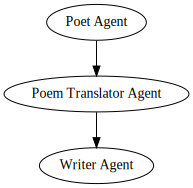

In [29]:
crew.plot()

In [31]:
crew.run()


RUNNING AGENT: Poet Agent

Life’s gentle whispers in the night,  
A dance 'neath stars, a fleeting sight.  
In fleeting moments, depths we find,  
Kind hearts, bold dreams, intertwined.  
Breathe, love, and let the spirits roam;  
In each small moment, we’re home.  

RUNNING AGENT: Poem Translator Agent

En medio de las estrellas donde los sueños habitan,  
La esencia de la vida florece mientras los momentos se deslizan,  
Un baile fugaz de alegrías y luchas,  
Donde el amor y el propósito miden la vida.  
En actos sencillos, tejemos nuestro arte,  
Conectando hilo a corazón por corazón.

Los suaves susurros de la vida en la noche,  
Un baile bajo las estrellas, una visión efímera.  
En momentos fugaces, profundidades encontramos,  
Corazones amables, sueños audaces, entrelazados.  
Respira, ama y deja que los espíritus vaguen;  
En cada pequeño momento, estamos en casa.

RUNNING AGENT: Writer Agent


Thought: I need to write the given Spanish poem into a text file named 'poem.txt'.

